In [1]:
from transformers import AutoTokenizer

# tested it with English, spanish, and urdu
# modified the logic to cater to urdu
def tokenize_with_mapping(sentence, tokenizer_name="xlm-roberta-base", lang = None):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=True)
    
    # Tokenize and get offset mappings
    encoded = tokenizer(
        sentence,
        return_offsets_mapping=True,
        return_attention_mask=False,
        return_tensors=None,
        add_special_tokens=False
    )
    
    tokens = tokenizer.convert_ids_to_tokens(encoded["input_ids"])
    offsets = encoded["offset_mapping"]

    word_map = []  # Stores index of full word for each subword
    words = []
    current_word = ""
    current_start = None

    if lang == 'ur':
        # word_map = []  # Stores index of full word for each subword
        # words = []
        # # current_word1 = ""
        # # current_start1 = None

        previous_token_start_index = None
        previous_token_end_index = None
        for i, (token, (start, end)) in enumerate(zip(tokens, offsets)):
            
            # this will run only once in the beginning
            if previous_token_start_index == None and previous_token_end_index == None:
                previous_token_start_index = start
                previous_token_end_index = end
                word_map.append(len(words))
                continue

            # chain the tokens using intersecting indices
            if previous_token_end_index == start or previous_token_end_index > start:
                previous_token_end_index = end
                word_map.append(len(words))
                continue
            
            # new word has begun
            if previous_token_end_index < start:
                # print(previous_token_start_index, previous_token_end_index)
                # print(sentence[previous_token_start_index:previous_token_end_index])
                words.append(sentence[previous_token_start_index:previous_token_end_index])
                word_map.append(len(words))
                previous_token_start_index = start
                previous_token_end_index = end


        # print(sentence[previous_token_start_index: previous_token_end_index])
        words.append(sentence[previous_token_start_index:previous_token_end_index])
        # word_map1.append(len(words1))


        # print(words)
        # print(word_map)

    else:
        # word_map = []  # Stores index of full word for each subword
        # words = []
        # current_word = ""
        # current_start = None

        for i, (token, (start, end)) in enumerate(zip(tokens, offsets)):
            if start == end:
                continue  # Special token or padding, skip it

            token_text = sentence[start:end]
            
            # New word boundary if:
            # - current_start is None (beginning), OR
            # - gap between previous end and current start
            if current_start is None or start > current_start:
                if current_word:
                    words.append(current_word)
                current_word = token_text
                current_start = end
                word_map.append(len(words))  # New word index
            else:
                current_word += token_text
                word_map.append(len(words))  # Same word index

        if current_word:
            words.append(current_word)


    return {
        "original_sentence": sentence,
        "tokens": tokens,
        "offsets": offsets,
        "words": words,
        "token_to_word_map": word_map,
        "input_ids": encoded["input_ids"]
    }

d:\Installed\ana\envs\kdd_task_1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from transformers import AutoModel

def get_word_embeddings(sentence, lang = None):
    tokenized = tokenize_with_mapping(sentence, lang = lang)
    print(tokenized)
    # input_ids = tokenizer.convert_tokens_to_ids(tokenized["tokens"])
    input_ids = tokenized["input_ids"]
    token_tensor = torch.tensor([input_ids])

    # model = AutoModelForMaskedLM.from_pretrained("FacebookAI/xlm-roberta-base")
    # model.eval()

    model = AutoModel.from_pretrained("xlm-roberta-base")
    model.eval()  # turn off dropout

    with torch.no_grad():
        outputs = model(token_tensor)
        token_embeddings = outputs.last_hidden_state.squeeze(0)

    token_to_word_map = tokenized["token_to_word_map"]
    word_embeddings = []
    current_word_index = -1
    current_vectors = []

    for i, word_idx in enumerate(token_to_word_map):
        if word_idx != current_word_index:
            if current_vectors:
                avg_vector = torch.stack(current_vectors).mean(dim=0)
                word_embeddings.append(avg_vector)
            current_vectors = []
            current_word_index = word_idx
        current_vectors.append(token_embeddings[i])

    if current_vectors:
        avg_vector = torch.stack(current_vectors).mean(dim=0)
        word_embeddings.append(avg_vector)

    return tokenized["words"], torch.stack(word_embeddings)


In [3]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def visualize_word_embeddings(sentence, method="tsne", lang=None, perplexity=30, random_state=42):
    """
    Visualizes word-level embeddings of a sentence in 2D using PCA or t-SNE.
    
    Args:
        sentence (str): Sentence to visualize.
        method (str): 'tsne' or 'pca'.
        lang (str or None): Optional language code.
        perplexity (int): Perplexity for t-SNE.
        random_state (int): Seed for reproducibility.
    """
    words, embeddings = get_word_embeddings(sentence, lang = lang)
    embeddings_np = embeddings.detach().numpy()
    n_samples = len(words)

    if n_samples < 2:
        print("Not enough words to visualize.")
        return

    # Step 2: Reduce to 2D
    if method.lower() == "tsne":
        adjusted_perplexity = min(perplexity, max(1, n_samples - 1))
        reducer = TSNE(n_components=2, perplexity=adjusted_perplexity, random_state=random_state)
    elif method.lower() == "pca":
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")
    
    reduced = reducer.fit_transform(embeddings_np)

    # Step 3: Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], color='skyblue')

    for i, word in enumerate(words):
        plt.text(reduced[i, 0], reduced[i, 1], word, fontsize=12)

    plt.title(f"Word Embeddings Visualization ({method.upper()})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()



{'original_sentence': 'computadora portátil', 'tokens': ['▁computador', 'a', '▁portátil'], 'offsets': [(0, 10), (10, 11), (12, 20)], 'words': ['computadora', 'portátil'], 'token_to_word_map': [0, 0, 1], 'input_ids': [80246, 11, 222295]}


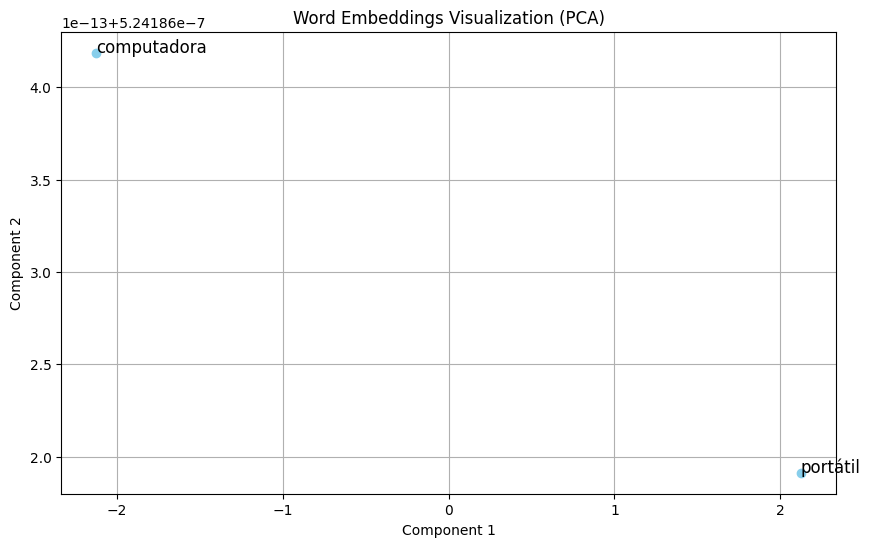

In [ ]:
## up till embeddings, english, spanish and urdu strings work
## for visualization, urdu is not working properly or maybe I did not understand 
#3 but due to lack of time I am unable to optmize it

visualize_word_embeddings("computadora portátil", method="pca")
# visualize_word_embeddings("How are you", method="pca")
# visualize_word_embeddings("یہ ایک جملہ ہے", method="pca", lang = 'ur')
